In [208]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [223]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary
special_tokens = ['.'] # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')

# mapping from chars to token number and vice-versa
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = vocab
encode = lambda char_seq: [ctoi[c] for c in char_seq]
decode = lambda token_num_seq: [itoc[t] for t in token_num_seq]
print(encode("vlad"), decode([22,12,1,4]))

# prepare dataset for NN training and validation
block_size = 3 # represents the length of context
def build_dataset(names):
    X, y = [], []
    for name in names:
        block = torch.zeros(block_size).to(torch.int64)
        for c in name + '.':
            ix = ctoi[c]
            X.append(block)
            y.append(ix)
            block = block.roll(-1)
            block[-1] = ix
    X, y = torch.stack(X), torch.tensor(y)
    return X, y

#train/validation/test split
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_dataset(names[:train_bound])
val_X, val_y = build_dataset(names[train_bound:val_bound])
test_X, test_y = build_dataset(names[val_bound:])
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(decode(train_X[i]))} => {itoc[train_y[i]]}')
print("val:")
for i in range(13):
    print(f'{"".join(decode(val_X[i]))} => {itoc[val_y[i]]}')
print("test:")
for i in range(13):
    print(f'{"".join(decode(test_X[i]))} => {itoc[test_y[i]]}')

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
X.shape=torch.Size([182681, 3]), y.shape=torch.Size([182681])
X.shape=torch.Size([22589, 3]), y.shape=torch.Size([22589])
X.shape=torch.Size([22876, 3]), y.shape=torch.Size([22876])
train_X.shape=torch.Size([182681, 3]), train_y.shape=torch.Size([182681]), val_X.shape=torch.Size([22589, 3]), val_y.shape=torch.Size([22589]), test_X.shape=torch.Size([22876, 3]), test_y.shape=torch.Size([22876])
train:
... => j
..j => e
.je => i
jei => l
eil => y
ily => n
lyn => .
... => r
..r => y
.ry => z
ryz => e
yze => .
... => k
val:
... => i
..i => s
.is => h
ish => m
shm => a
hma => e
mae => l
ael => .
... => a
..a => d
.ad => r
adr => i
dri => e
test:
... => k
..k => r
.kr => o
kro => s
ros => s
oss => .
... => c
..c => l
.cl => a
cla => r
lar =>

### Define training loop and Evaluation method

In [278]:
def train(model, train_X, train_y, val_X, val_y, epoches, batch_size, lr=1e-3):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        ids = torch.randperm(train_X.shape[0])
        cur_losses = []
        for batch_ids_lb in range(0, train_X.shape[0], batch_size):
            batch_ids = ids[batch_ids_lb:batch_ids_lb+batch_size]
            mini_batch_X = train_X[batch_ids].to(device)
            mini_batch_y = train_y[batch_ids].to(device)
            logits = model(mini_batch_X)
            loss = F.cross_entropy(logits, mini_batch_y)
            cur_losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            model.optimize(lr = lr)
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_X), val_y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss


@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

In [246]:
class MLP:
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, device='cpu'):
        self.context_size = block_size*emb_size
        self.emb = torch.randn((vocab_size, emb_size), requires_grad = True, device = device)
        self.W1 = torch.randn((self.context_size, hidden_size), requires_grad = True, device = device)
        self.b1 = torch.randn(hidden_size, requires_grad = True, device = device)
        self.W2 = torch.randn((hidden_size, vocab_size), requires_grad = True, device = device)
        self.b2 = torch.randn(vocab_size, requires_grad = True, device = device)
    
    def forward(self, mini_batch_X):
        embeddings  = self.emb[mini_batch_X]
        concat_embs = embeddings.view(-1, self.context_size)
        out1 = concat_embs @ self.W1 + self.b1
        out1 = F.tanh(out1)
        out2 = out1 @ self.W2 + self.b2
        return out2

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def optimize(self, lr):
        for p in self.parameters():
            p.data -= lr*p.grad

    def parameters(self):
        return [self.emb, self.W1, self.b1, self.W2, self.b2]

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def __call__(self, mini_batch_X):
        return self.forward(mini_batch_X)

model.nelement()=4433
epoch=0: cur_avg_train_loss=2.7666857048007945, cur_val_loss=2.7125062942504883
epoch=1: cur_avg_train_loss=2.5164856500675716, cur_val_loss=2.525550603866577
epoch=2: cur_avg_train_loss=2.4825586249239597, cur_val_loss=2.4961893558502197
epoch=3: cur_avg_train_loss=2.457539295983189, cur_val_loss=2.455648183822632
epoch=4: cur_avg_train_loss=2.4427207526726398, cur_val_loss=2.479430913925171
epoch=5: cur_avg_train_loss=2.4315096380414145, cur_val_loss=2.4662413597106934
epoch=6: cur_avg_train_loss=2.421716611731908, cur_val_loss=2.4478588104248047
epoch=7: cur_avg_train_loss=2.414546715231994, cur_val_loss=2.4781136512756348
epoch=8: cur_avg_train_loss=2.40948101572314, cur_val_loss=2.4799885749816895
epoch=9: cur_avg_train_loss=2.401956712343647, cur_val_loss=2.4142191410064697
epoch=10: cur_avg_train_loss=2.39661434648751, cur_val_loss=2.4618091583251953
epoch=11: cur_avg_train_loss=2.3904594021377963, cur_val_loss=2.4366424083709717
epoch=12: cur_avg_train_los

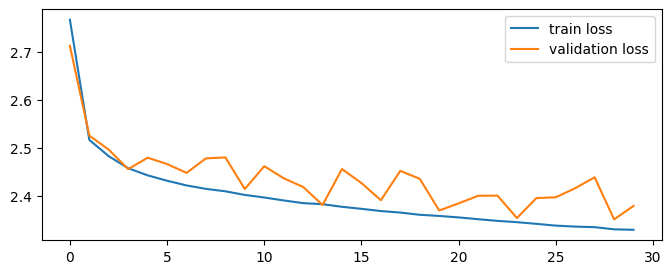

In [251]:
model = MLP(vocab_size, block_size, emb_size=2, hidden_size=128, device=device)
print(f'{model.nelement()=}')
train_loss, val_loss = train(model, train_X, train_y, val_X.to(device), val_y.to(device), epoches=30, batch_size=64, lr=0.1)
plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [253]:
for i in range(10):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

aly.
mirion.
brinjitk.
aubariya.
dyun.
son.
mrangh.
kee.
vau.
bloaz.


### Visualize 2D embeddings

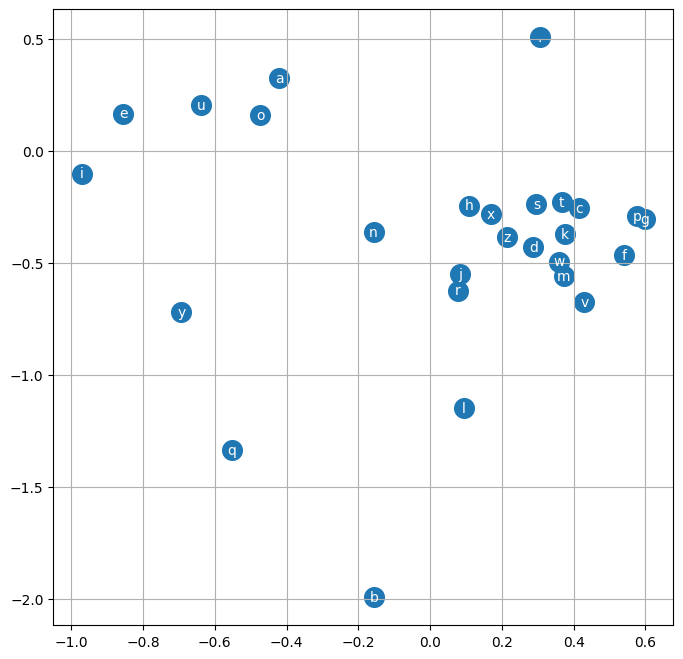

In [260]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Scale-up the model

model384.nelement()=22569
epoch=0: cur_avg_train_loss=4.537107204180048, cur_val_loss=3.3436193466186523
epoch=1: cur_avg_train_loss=2.8663437752297796, cur_val_loss=2.984354019165039
epoch=2: cur_avg_train_loss=2.697152230284469, cur_val_loss=3.1005892753601074
epoch=3: cur_avg_train_loss=2.6289448362724586, cur_val_loss=2.908522605895996
epoch=4: cur_avg_train_loss=2.5842694454560555, cur_val_loss=2.7352471351623535
epoch=5: cur_avg_train_loss=2.551323105491398, cur_val_loss=2.6226818561553955
epoch=6: cur_avg_train_loss=2.5272387639027345, cur_val_loss=2.7434778213500977
epoch=7: cur_avg_train_loss=2.507199018097592, cur_val_loss=2.6827163696289062
epoch=8: cur_avg_train_loss=2.492223301827386, cur_val_loss=2.7193729877471924
epoch=9: cur_avg_train_loss=2.4761044017905323, cur_val_loss=2.683624744415283
epoch=10: cur_avg_train_loss=2.4687238843553745, cur_val_loss=2.7304656505584717
epoch=11: cur_avg_train_loss=2.4529719223700557, cur_val_loss=2.709752082824707
epoch=12: cur_avg_tra

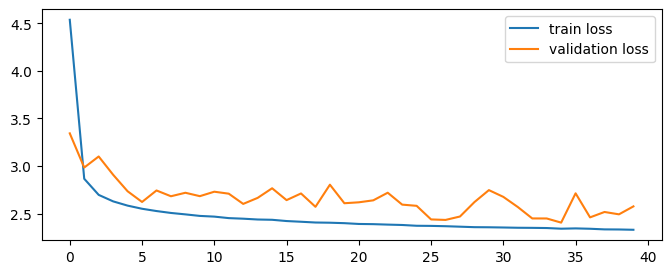

In [271]:
model384 = MLP(vocab_size, block_size, emb_size=10, hidden_size=384, device=device)
print(f'{model384.nelement()=}')
train_loss, val_loss = train(model384, train_X, train_y, val_X.to(device), val_y.to(device), epoches=40, batch_size=64, lr=0.1)

plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [272]:
for i in range(10):
    print(''.join(decode(evaluate(model384, max_new_tokens=1000))))

bro.
cene.
dechennediaigenii.
kesia.
ebaishaureytani.
kenduadhariaei.
eddajiha.
keya.
charidenahishahiree.
jenevedyn.


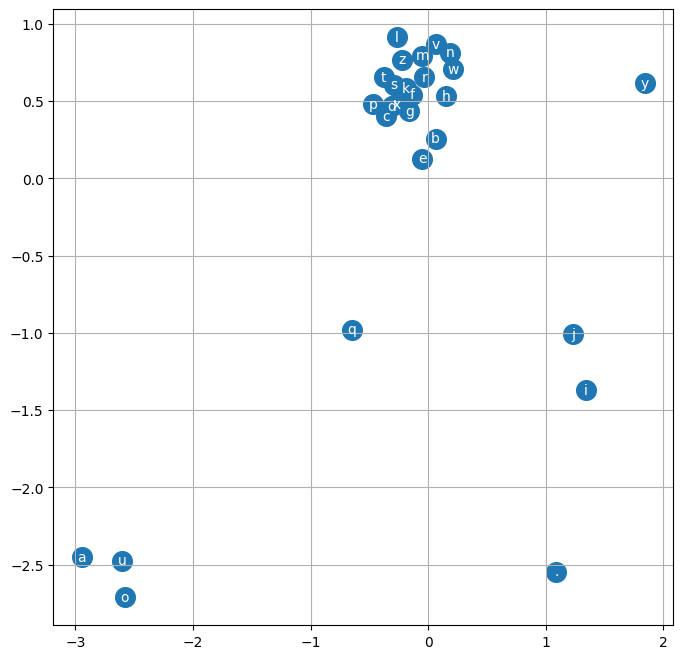

In [273]:
# visualize some 2 dimensions of the embedding matrix model384.emb for all characters
plt.figure(figsize=(8,8))
C = model384.emb.cpu()
dim1, dim2 = 4, 5
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Test evaluation

In [277]:
with torch.no_grad():
    test_logits = model384(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5710)


### Build pyTorch-like classes and model

In [551]:
from functools import reduce
class Linear:
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        self.W = torch.randn([in_features, out_features], dtype=dtype, device=device, generator=gen)
        self.b = torch.randn(out_features, dtype=dtype, device=device, generator=gen) if bias else None

    def __call__(self, X):
        self.out = X @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(self.parameters())


class Tanh():
    def __call__(self, X):
        self.out = torch.tanh(X)
        return self.out

    def parameters(self):
        return []


class MultiLayerPerceptron:
    def __init__(self, vocab_size, block_size, n_emb, n_hidden, linear_layer=Linear, device='cpu', gen=None):
        self.context_size = n_emb * block_size
        self.emb_table = torch.randn((vocab_size, n_emb), device=device, generator=gen)
        self.layers = [
            linear_layer(self.context_size, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, vocab_size, device=device, gen=gen)
        ]
        for p in self.parameters():
            p.requires_grad = True

    def __call__(self, X):
        emb = self.emb_table[X].view(-1, self.context_size)
        return reduce(lambda out, L: L(out), self.layers, emb)

    def parameters(self):
        return [self.emb_table] + [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def retain_grad(self):
        for L in self.layers:
            L.out.retain_grad()


class SgdOptimizer:
    def __init__(self, parameters, learning_rate_provider):
        self.parameters = parameters
        self.lr_provider = learning_rate_provider
        self.update_data_ratio = []

    def step(self):
        lr = self.lr_provider.get()
        for p in self.parameters:
            p.data -= lr*p.grad
        with torch.no_grad():
            self.update_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in self.parameters])

class ConstatntLr:
    def __init__(self, lr):
        self.lr = lr

    def get(self):
        return self.lr

class TensorDataset:
    def __init__(self, X, y, device='cpu'):
        self.X = X.to(device)
        self.y = y.to(device)
        self.ids = list(range(X.shape[0]))
        self.l_bord = 0

    def reshuffle(self):
        random.shuffle(self.ids)
        self.l_bord = 0

    def is_processed(self):
        return self.l_bord >= self.X.shape[0]

    def get_mini_batch(self, batch_size, device='cpu'):
        if self.is_processed():
            print("Warning. Current shuffle is processed. Reshuffling...")
            self.reshuffle()
        batch_ids = self.ids[self.l_bord:self.l_bord+batch_size]
        if len(batch_ids) < batch_size:
            k = batch_size - len(batch_ids)
            extra_ids = random.sample(range(self.l_bord), k)
            batch_ids.extend(extra_ids)
        mini_batch_X = train_X[batch_ids].to(device)
        mini_batch_y = train_y[batch_ids].to(device)
        self.l_bord += batch_size
        return mini_batch_X, mini_batch_y

### new training loop

In [541]:
def train_step(model, mini_batch_X, mini_batch_y, optimizer):
    logits = model(mini_batch_X)
    loss = F.cross_entropy(logits, mini_batch_y)
    model.retain_grad()
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def train2(model, train_dataset, val_dataset, epoches, batch_size, optimizer):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        train_dataset.reshuffle()
        cur_losses = []
        while not train_dataset.is_processed():
            mini_batch_X, mini_batch_y = train_dataset.get_mini_batch(batch_size, device)
            loss = train_step(model, mini_batch_X, mini_batch_y, optimizer)
            cur_losses.append(loss.item())
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_dataset.X), val_dataset.y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss

### Activations visualizations

In [542]:
# visualize histograms
def plot_forward_activations(model, layer_type=None):
    plt.figure(figsize=(20, 4)) # width and height of the plot
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.to('cpu')
            saturation = (t.abs() > 0.97).float().mean()*100
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer_name, t.mean(), t.std(), saturation))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


def plot_backward_gradients(model, layer_type=None):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.grad.to('cpu')
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+f, std %e' % (i, layer_name, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')


def visualize_weights_gradients(model):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(model.parameters()):
        t = p.grad.to('cpu')
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');


def visualize_gradient_to_weight_ratio(optimizer):
    plt.figure(figsize=(20, 4))
    legends = []
    ud = optimizer.update_data_ratio
    for i,p in enumerate(optimizer.parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

model.nelement()=57257
init_t_loss=24.352346420288086, init_v_loss=24.18595314025879
layer 1 (      Tanh): mean +0.02, std 0.92, saturated: 67.68%
layer 3 (      Tanh): mean +0.00, std 0.96, saturated: 84.54%
layer 5 (      Tanh): mean -0.01, std 0.96, saturated: 84.05%
layer 7 (      Tanh): mean -0.01, std 0.96, saturated: 84.82%


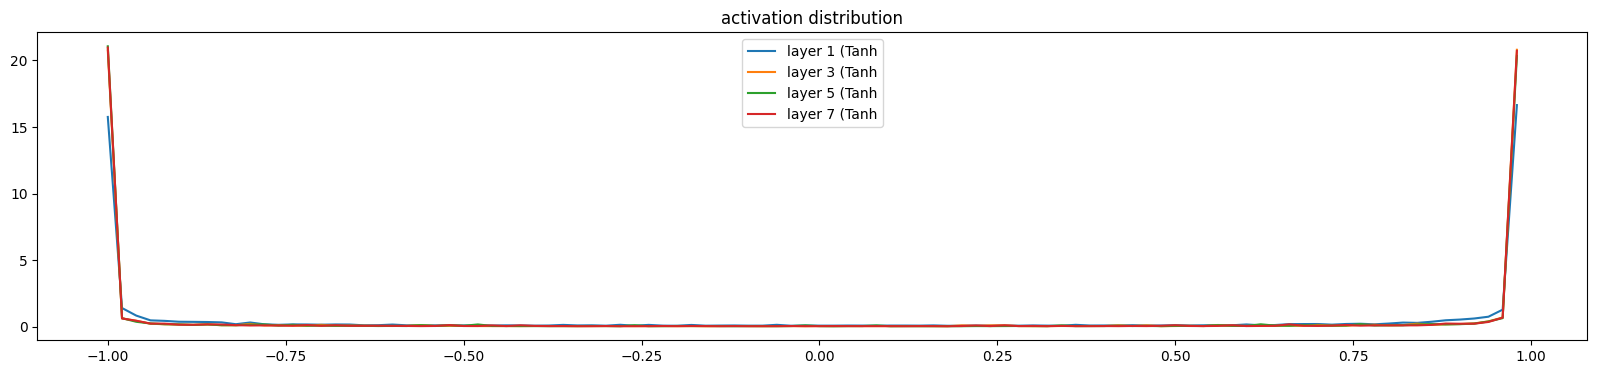

In [543]:
g = torch.Generator(device=device).manual_seed(7877)

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")
plot_forward_activations(model, layer_type=Tanh)

#### Given the plot above we see that randomly initialized weights produce almost saturated tanh activations, so gradient signal on backward pass will be to small to learn effectively.

layer 1 (      Tanh): mean +0.010100, std 3.210429e-01
layer 3 (      Tanh): mean -0.000151, std 1.282860e-01
layer 5 (      Tanh): mean -0.000765, std 4.817660e-02
layer 7 (      Tanh): mean +0.000327, std 2.034999e-02


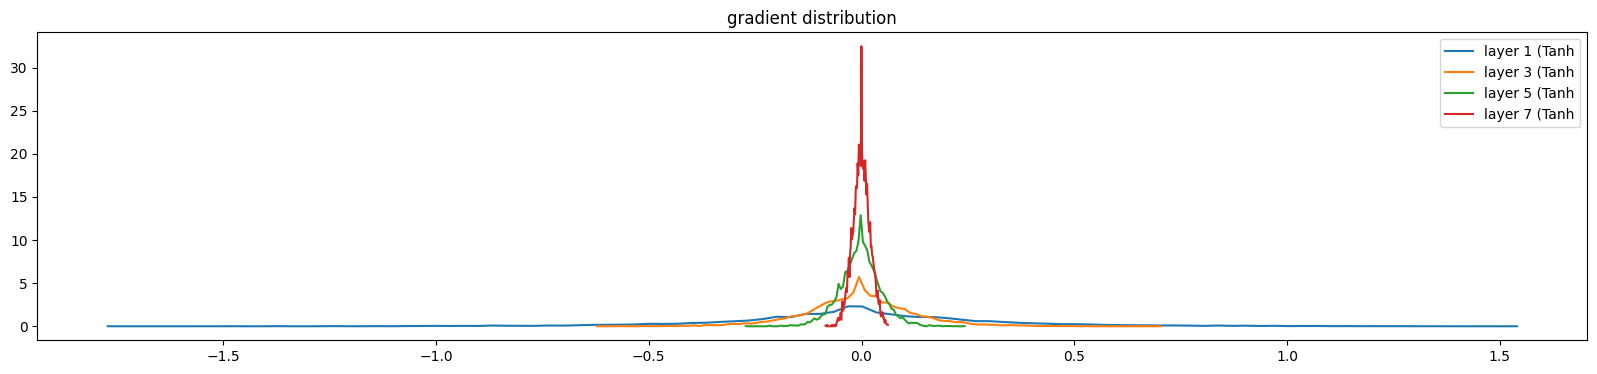

In [544]:
mb_X, mb_y = train_ds.get_mini_batch(64, device)
train_step(model, mb_X, mb_y, optimizer)
plot_backward_gradients(model, Tanh)

#### On the plot above we see the spreading of gradient distribution from last to very first layer (as a result of saturated tanh). It makes first layers difficult to learn as they get small gradient signal. It is called 'gradient vanishing'

weight   (27, 10) | mean -0.177626 | std 4.238103e+00 | grad:data ratio 4.206956e+00
weight  (30, 128) | mean -0.019062 | std 1.138505e+00 | grad:data ratio 1.154423e+00
weight (128, 128) | mean +0.000429 | std 3.270231e-01 | grad:data ratio 3.235153e-01
weight (128, 128) | mean +0.001514 | std 1.338918e-01 | grad:data ratio 1.331834e-01
weight (128, 128) | mean +0.000085 | std 4.425577e-02 | grad:data ratio 4.408982e-02
weight  (128, 27) | mean -0.000000 | std 4.282732e-02 | grad:data ratio 4.368010e-02


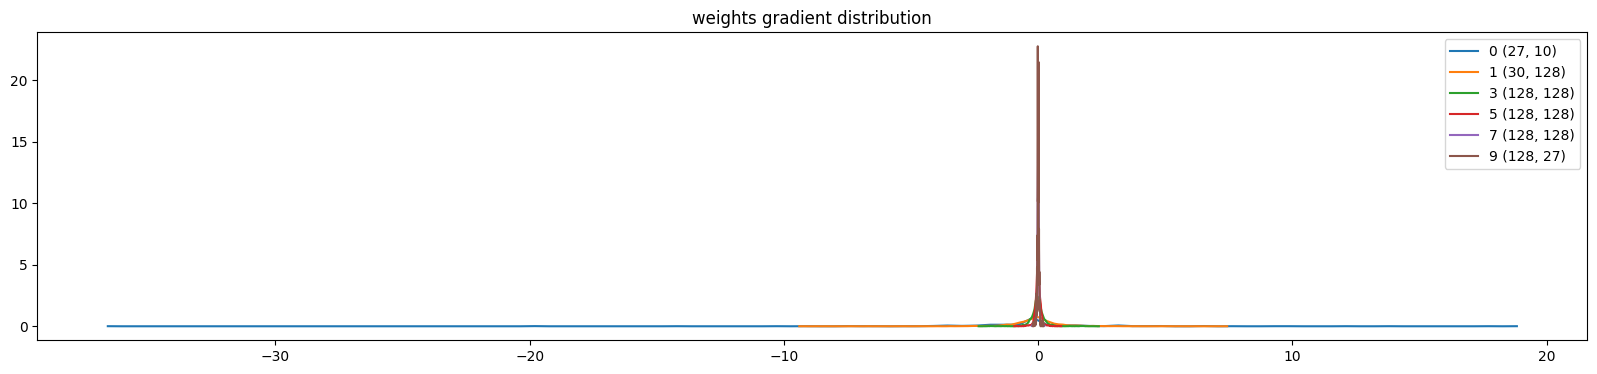

In [545]:
visualize_weights_gradients(model)

#### Weights gradients are not well distributed as well. Last layers have about 10 times bigger gradients, so they learn 10 times faster in the beginning

epoch=0: cur_avg_train_loss=14.489750367236802, cur_val_loss=12.0377836227417


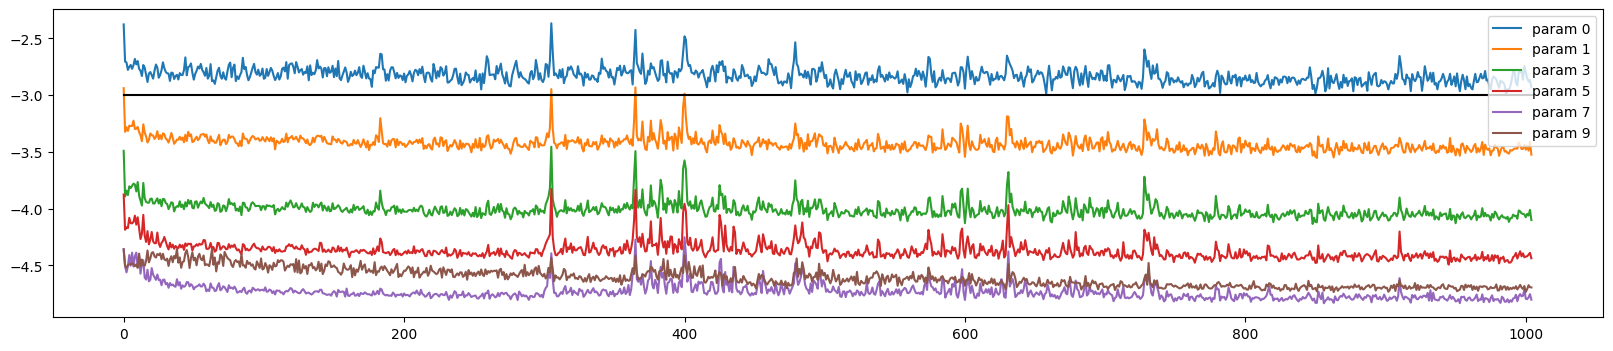

In [546]:
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
visualize_gradient_to_weight_ratio(optimizer)

#### Last plot represents update to weight ratio in logarithmic scale. This ratio represents "how big is the value we use to change weight comparing with weight itself". Good value for that ratio is approx -3. Current plot shows at least 4 last parameters which have 10000 times smaller update value in comparison to weight value.

### Final training of model w/o sophisticated initialization

In [547]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=22.740550994873047, init_v_loss=22.746915817260742
epoch=0: cur_avg_train_loss=14.567042794360583, cur_val_loss=12.540712356567383
epoch=1: cur_avg_train_loss=11.574765436202881, cur_val_loss=10.912856101989746
epoch=2: cur_avg_train_loss=10.175031073064918, cur_val_loss=9.784379959106445
epoch=3: cur_avg_train_loss=9.236759615134433, cur_val_loss=9.026915550231934
epoch=4: cur_avg_train_loss=8.609389706436856, cur_val_loss=8.510573387145996
epoch=5: cur_avg_train_loss=8.1498530618698, cur_val_loss=8.123495101928711
epoch=6: cur_avg_train_loss=7.792167050904962, cur_val_loss=7.789858341217041
epoch=7: cur_avg_train_loss=7.457093098249094, cur_val_loss=7.4872517585754395
epoch=8: cur_avg_train_loss=7.190165700190571, cur_val_loss=7.254659175872803
epoch=9: cur_avg_train_loss=6.959921477800346, cur_val_loss=7.031979084014893
epoch=10: cur_avg_train_loss=6.750685651463816, cur_val_loss=6.839646816253662
epoch=11: cur_avg_train_loss=6.569610001556427, cur

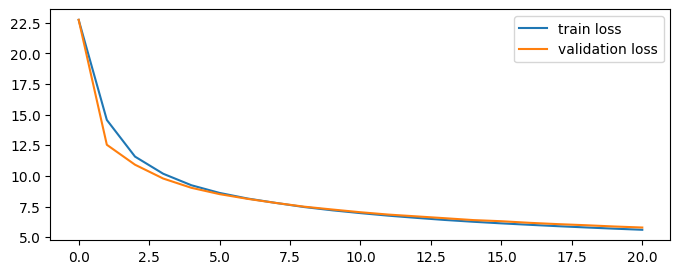

In [548]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [549]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

dgkemarnnlnfoi.
namase.
.
ysexdvljmyjsfel.
jetithqihgfkxadmflwdylcn.
gvcgwsvizuzeyan.
ysremiasqtvhgnlqilnzy.
herar.
hana.
euynphyzutladr.
mamiexiecn.
jumeldovmoqieter.
janely.
gvcgwyjsfeldzutbnagj.
nan.


In [550]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(5.8005)


### Normalize weights in Linear layer

In [556]:
class LinearNormalized(Linear):
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        super().__init__(in_features, out_features, bias=bias, device=device, dtype=dtype, gen=gen)
        self.W /= in_features ** 0.5

model.nelement()=57257
init_t_loss=4.003686428070068, init_v_loss=4.0010480880737305
layer 1 (      Tanh): mean +0.07, std 0.70, saturated: 11.39%
layer 3 (      Tanh): mean -0.03, std 0.66, saturated: 8.46%
layer 5 (      Tanh): mean +0.05, std 0.68, saturated: 5.74%
layer 7 (      Tanh): mean -0.16, std 0.66, saturated: 6.49%


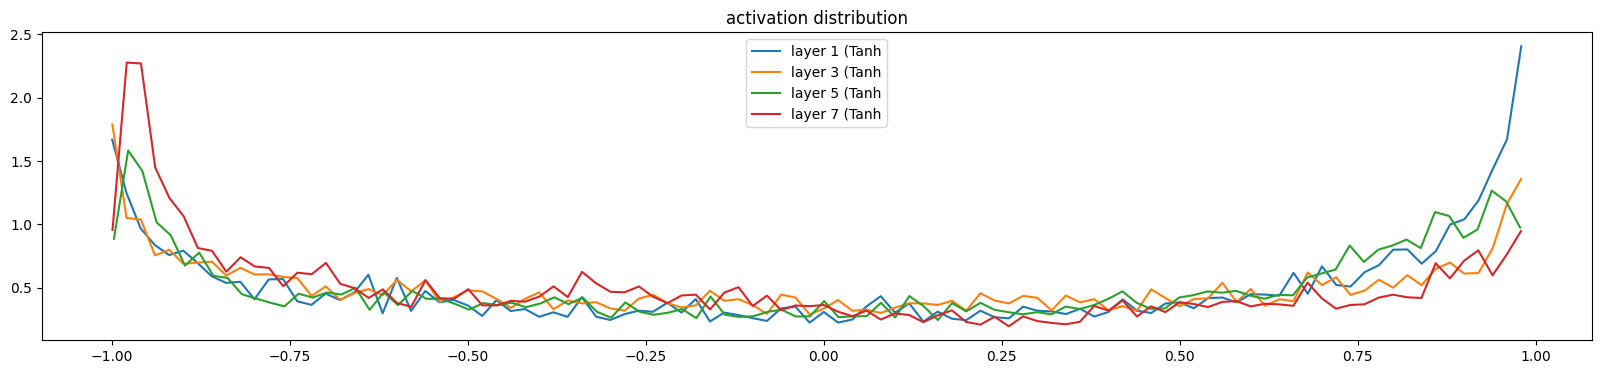

In [557]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(
    vocab_size,
    block_size,
    n_emb=10,
    n_hidden=128,
    linear_layer=LinearNormalized,
    device=device,
    gen=g
)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")
plot_forward_activations(model, layer_type=Tanh)

#### Now activations on tanh not so saturated as before normalization.

Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000005, std 3.542718e-04
layer 3 (      Tanh): mean -0.000012, std 5.615434e-04
layer 5 (      Tanh): mean -0.000018, std 8.637065e-04
layer 7 (      Tanh): mean +0.000007, std 1.336225e-03


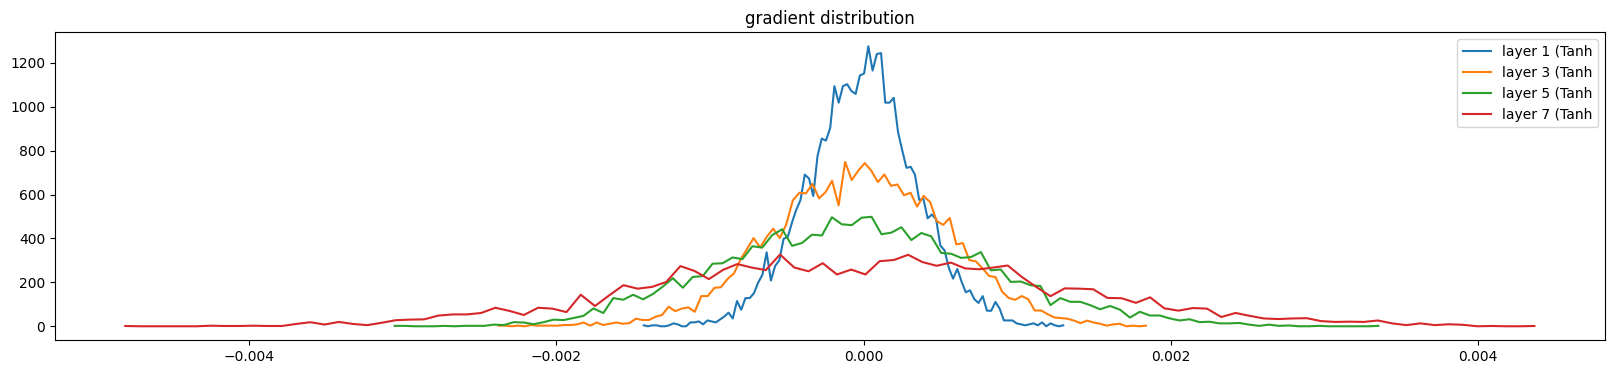

In [558]:
mb_X, mb_y = train_ds.get_mini_batch(64, device)
train_step(model, mb_X, mb_y, optimizer)
plot_backward_gradients(model, Tanh)

#### gradients become better at first layers

weight   (27, 10) | mean -0.000058 | std 1.196626e-03 | grad:data ratio 1.187841e-03
weight  (30, 128) | mean -0.000035 | std 1.718453e-03 | grad:data ratio 9.543982e-03
weight (128, 128) | mean -0.000033 | std 2.873756e-03 | grad:data ratio 3.216410e-02
weight (128, 128) | mean -0.000001 | std 4.834459e-03 | grad:data ratio 5.440627e-02
weight (128, 128) | mean +0.000046 | std 9.067510e-03 | grad:data ratio 1.022025e-01
weight  (128, 27) | mean +0.000000 | std 3.236620e-02 | grad:data ratio 3.734722e-01


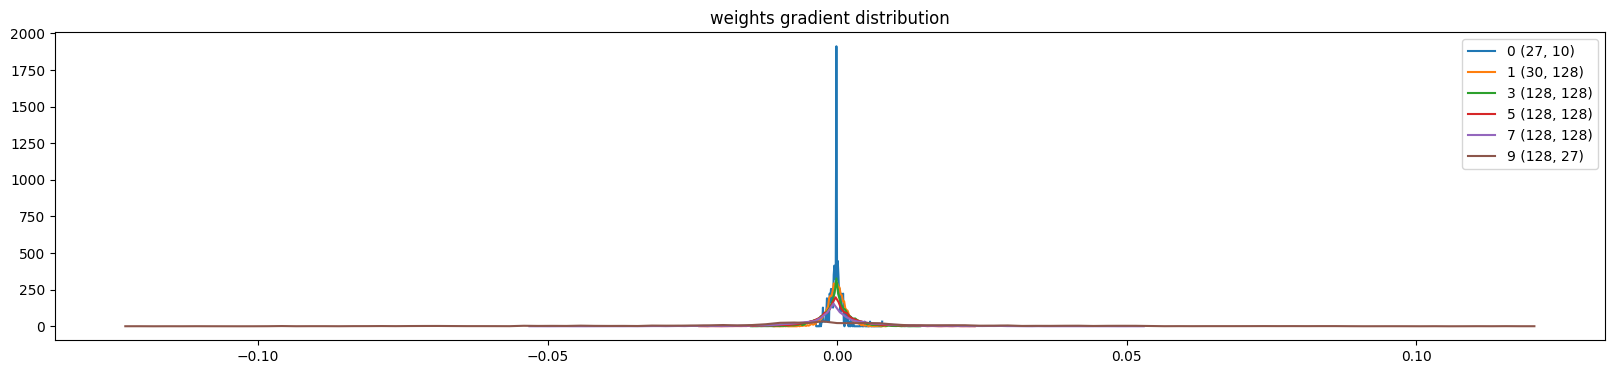

In [559]:
visualize_weights_gradients(model)

#### Weights gradients are not well distributed still

epoch=0: cur_avg_train_loss=3.0343359167357367, cur_val_loss=2.8205111026763916


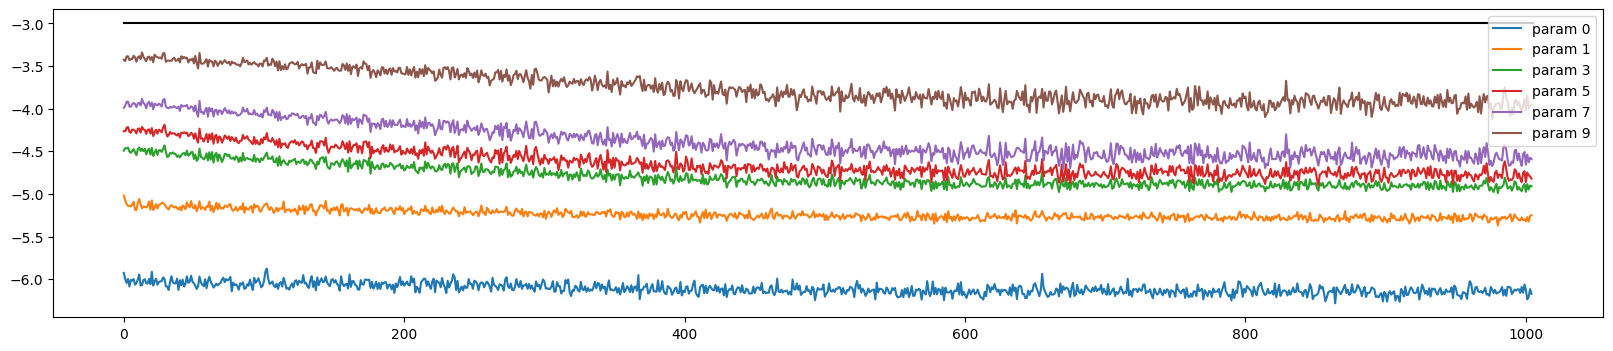

In [560]:
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
visualize_gradient_to_weight_ratio(optimizer)

#### update to weight ratio become worser. we need to apply more sophisticated initialization

In [561]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=4.032634735107422, init_v_loss=4.033323287963867
epoch=0: cur_avg_train_loss=3.0012003290225784, cur_val_loss=2.8174917697906494
epoch=1: cur_avg_train_loss=2.8022861604196616, cur_val_loss=2.7798211574554443
epoch=2: cur_avg_train_loss=2.7732871417030394, cur_val_loss=2.753541946411133
epoch=3: cur_avg_train_loss=2.7478130046589917, cur_val_loss=2.7289977073669434
epoch=4: cur_avg_train_loss=2.7239302817093898, cur_val_loss=2.7061045169830322
epoch=5: cur_avg_train_loss=2.7014585389084074, cur_val_loss=2.6847875118255615
epoch=6: cur_avg_train_loss=2.680605416516384, cur_val_loss=2.6652121543884277
epoch=7: cur_avg_train_loss=2.661601621791186, cur_val_loss=2.64743709564209
epoch=8: cur_avg_train_loss=2.644425592336997, cur_val_loss=2.6315555572509766
epoch=9: cur_avg_train_loss=2.6291275223887776, cur_val_loss=2.617231607437134
epoch=10: cur_avg_train_loss=2.6153978598545273, cur_val_loss=2.6045141220092773
epoch=11: cur_avg_train_loss=2.60278390911

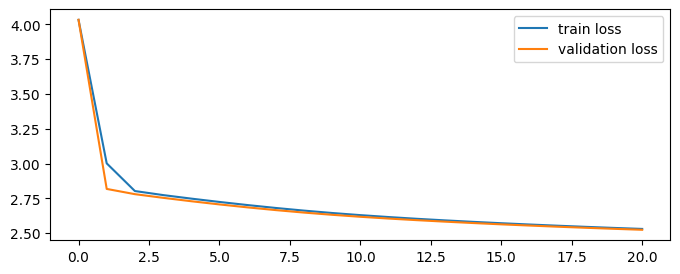

In [562]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

#### After adding single initialization feature we see much better results in training 

In [564]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

shrilen.
riminahen.
aderlenntinooermhy.
man.
celminnr.
ccanilefnoe.
kaypae.
jadheli.
lantiel.
kanaie.
va.
llin.
avslaa.
mer.
iel.


In [563]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5338)


### Complete calculating the init scale (Kaiming init): adding gain
- for details: 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)'
- concept: At initialization we want to maintain distribution of activations on each layer with same mean and std. Its is can be done by initialization of linear layer weights by sampling N(0,std^2) where std = gain/sqrt(in_features)

In [565]:
class LinearWithGain(LinearNormalized):
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        super().__init__(in_features, out_features, bias=bias, device=device, dtype=dtype, gen=gen)
        self.W *= 5/3 # a good gain value for tanh() activations

model.nelement()=57257
init_t_loss=4.405800819396973, init_v_loss=4.40297794342041
layer 1 (      Tanh): mean +0.05, std 0.77, saturated: 23.93%
layer 3 (      Tanh): mean -0.02, std 0.75, saturated: 19.46%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 17.71%
layer 7 (      Tanh): mean -0.14, std 0.73, saturated: 17.86%


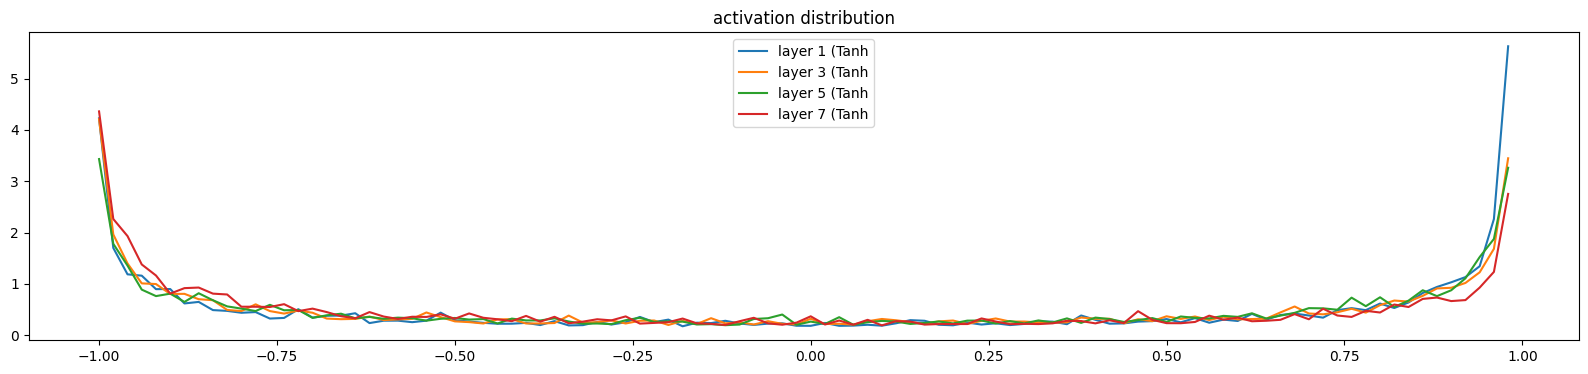

In [567]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(
    vocab_size,
    block_size,
    n_emb=10,
    n_hidden=128,
    linear_layer=LinearWithGain,
    device=device,
    gen=g
)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")
plot_forward_activations(model, layer_type=Tanh)

#### Slightly hight satturation in the begining

Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000013, std 1.998204e-03
layer 3 (      Tanh): mean -0.000035, std 2.163351e-03
layer 5 (      Tanh): mean -0.000041, std 2.256009e-03
layer 7 (      Tanh): mean -0.000082, std 2.301548e-03


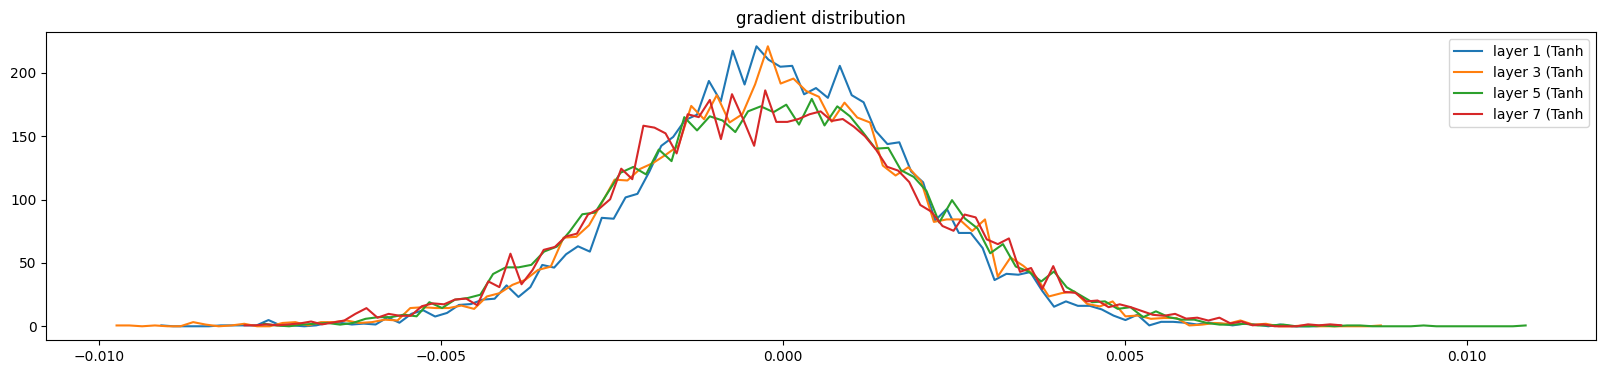

In [568]:
mb_X, mb_y = train_ds.get_mini_batch(64, device)
train_step(model, mb_X, mb_y, optimizer)
plot_backward_gradients(model, Tanh)

#### gradients per layer distributed very well

weight   (27, 10) | mean -0.000703 | std 1.117490e-02 | grad:data ratio 1.109286e-02
weight  (30, 128) | mean -0.000166 | std 8.949642e-03 | grad:data ratio 2.982282e-02
weight (128, 128) | mean +0.000011 | std 1.044978e-02 | grad:data ratio 7.017461e-02
weight (128, 128) | mean +0.000084 | std 1.299720e-02 | grad:data ratio 8.776117e-02
weight (128, 128) | mean -0.000030 | std 1.669854e-02 | grad:data ratio 1.129285e-01
weight  (128, 27) | mean +0.000000 | std 4.522270e-02 | grad:data ratio 3.130966e-01


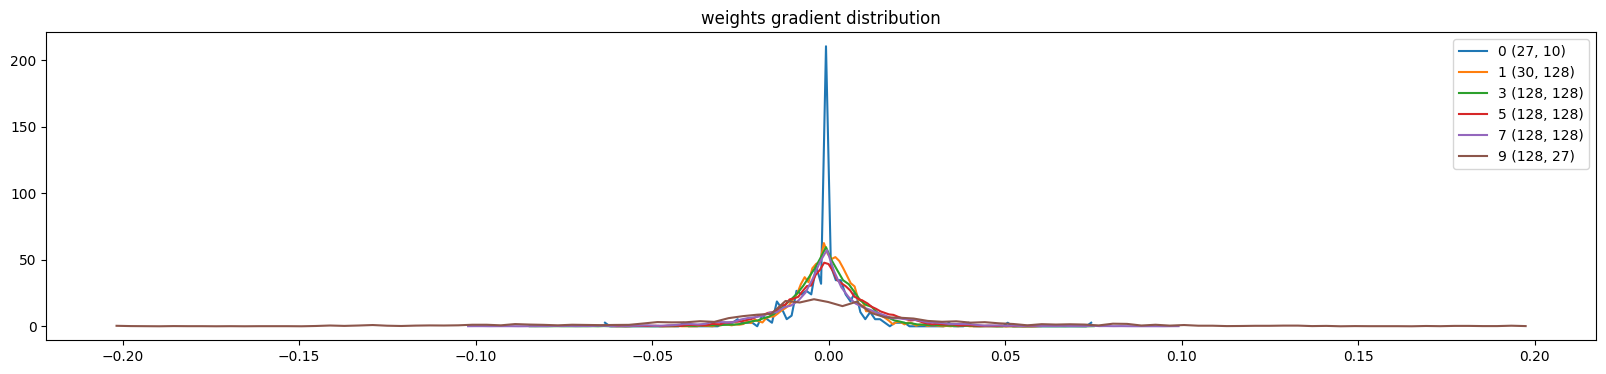

In [569]:
visualize_weights_gradients(model)

#### Weights gradients are good enougth

epoch=0: cur_avg_train_loss=3.1063044140063436, cur_val_loss=2.814560890197754


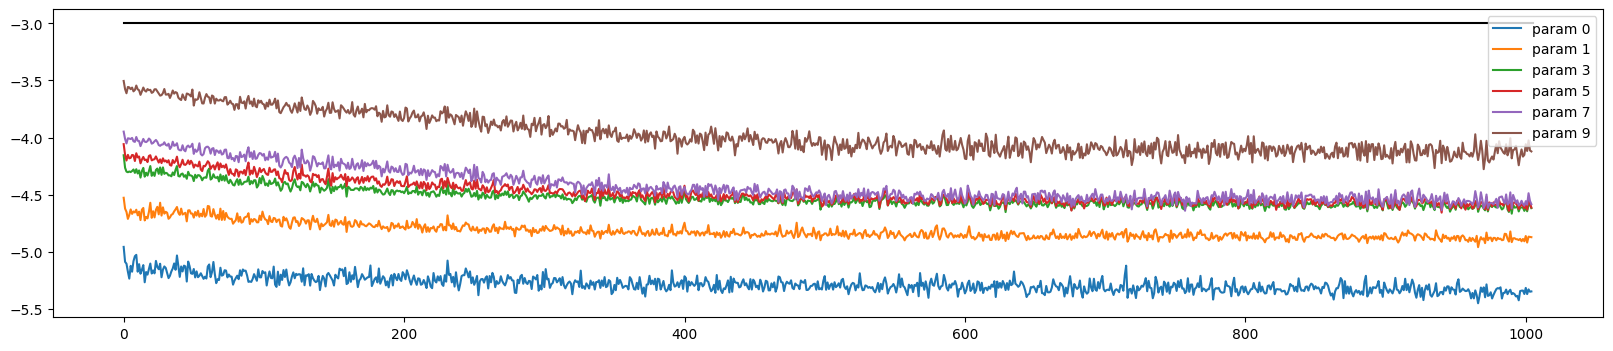

In [570]:
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
visualize_gradient_to_weight_ratio(optimizer)

### We see that whatever the initialization feature we apply the update:weight ratio still not good enougth. That indicates that we should increase learining rate to make this ratio arrount -3

In [575]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=3.880333185195923, init_v_loss=3.8646976947784424
epoch=0: cur_avg_train_loss=3.0109856926587475, cur_val_loss=2.816627025604248
epoch=1: cur_avg_train_loss=2.7934982456059094, cur_val_loss=2.758323907852173
epoch=2: cur_avg_train_loss=2.746455905446968, cur_val_loss=2.720653533935547
epoch=3: cur_avg_train_loss=2.7141674410299474, cur_val_loss=2.6935386657714844
epoch=4: cur_avg_train_loss=2.6899072007828972, cur_val_loss=2.672318458557129
epoch=5: cur_avg_train_loss=2.6697918171901627, cur_val_loss=2.6542530059814453
epoch=6: cur_avg_train_loss=2.6523325127434445, cur_val_loss=2.6379168033599854
epoch=7: cur_avg_train_loss=2.636278876270431, cur_val_loss=2.623142719268799
epoch=8: cur_avg_train_loss=2.621579965984679, cur_val_loss=2.6093084812164307
epoch=9: cur_avg_train_loss=2.608085661770338, cur_val_loss=2.596510887145996
epoch=10: cur_avg_train_loss=2.59536731528096, cur_val_loss=2.5847325325012207
epoch=11: cur_avg_train_loss=2.58383396897183,

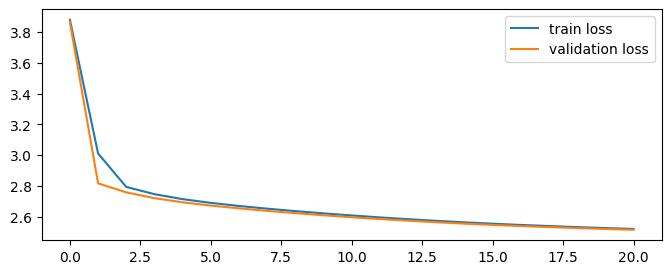

In [576]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [577]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

moeanllmee.
nsvhoteehye.
zranlpla.
yatakearone.
dariuareos.
jharecbnq.
aejiyoh.
jesbiyam.
jamckaneusnene.
rdbhnd.
animalsianni.
marenlecw.
oyahnhia.
edanelsm.
oekaneuryad.


In [578]:
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5255)


#### Slightly better results on test dataset and in training. Generated samples looks as bad as in previous model

### Increase learning rate

- given update:weight ratio plots we see that learning rate can be increased slightly to make update:weight = 1:1000
- according to last plot we can make a learning_rate for last model 10-100 times bigger

model.nelement()=57257
init_t_loss=4.405800819396973, init_v_loss=4.40297794342041
layer 1 (      Tanh): mean +0.05, std 0.77, saturated: 23.93%
layer 3 (      Tanh): mean -0.02, std 0.75, saturated: 19.46%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 17.71%
layer 7 (      Tanh): mean -0.14, std 0.73, saturated: 17.86%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000012, std 2.019989e-03
layer 3 (      Tanh): mean -0.000027, std 2.142219e-03
layer 5 (      Tanh): mean -0.000039, std 2.200290e-03
layer 7 (      Tanh): mean -0.000041, std 2.299837e-03
weight   (27, 10) | mean -0.000413 | std 1.341059e-02 | grad:data ratio 1.331222e-02
weight  (30, 128) | mean -0.000030 | std 1.220286e-02 | grad:data ratio 4.066344e-02
weight (128, 128) | mean +0.000028 | std 1.182967e-02 | grad:data ratio 7.944171e-02
weight (128, 128) | mean -0.000016 | std 1.352039e-02 | grad:data ratio 9.129723e-02
weight (128, 128) | mean +0.000001 | std 1.569700e-02 |

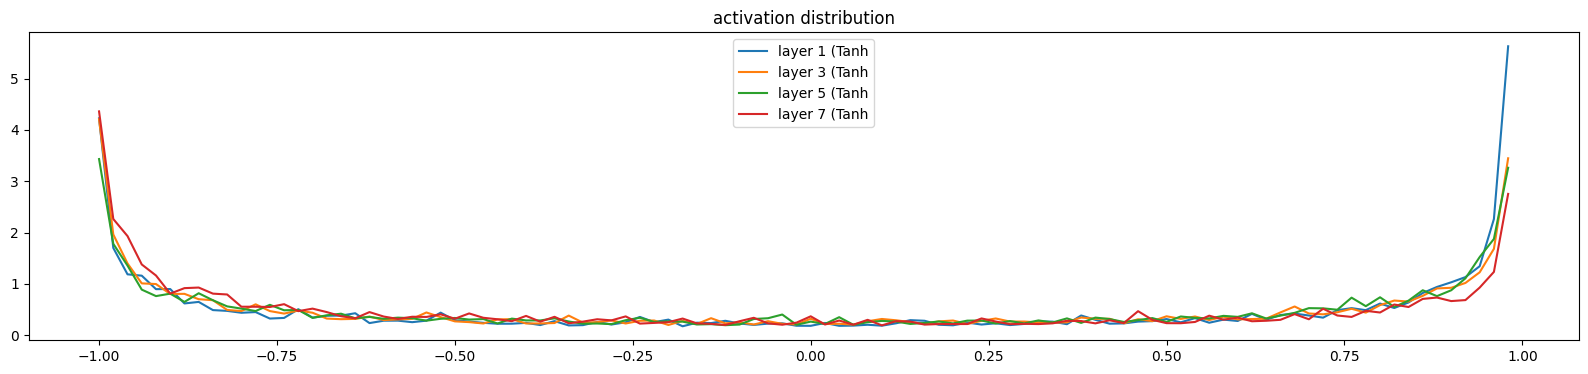

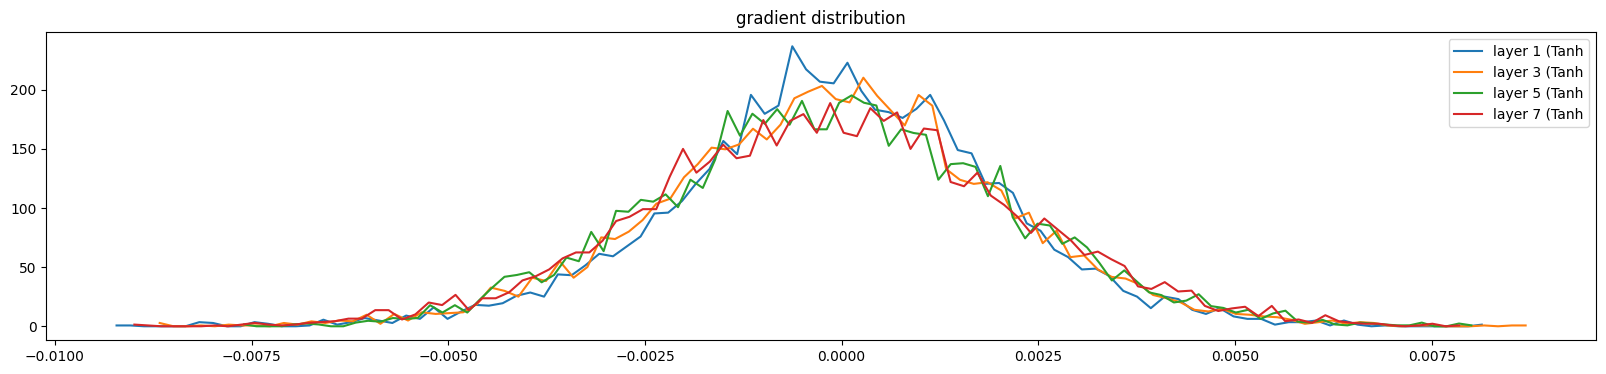

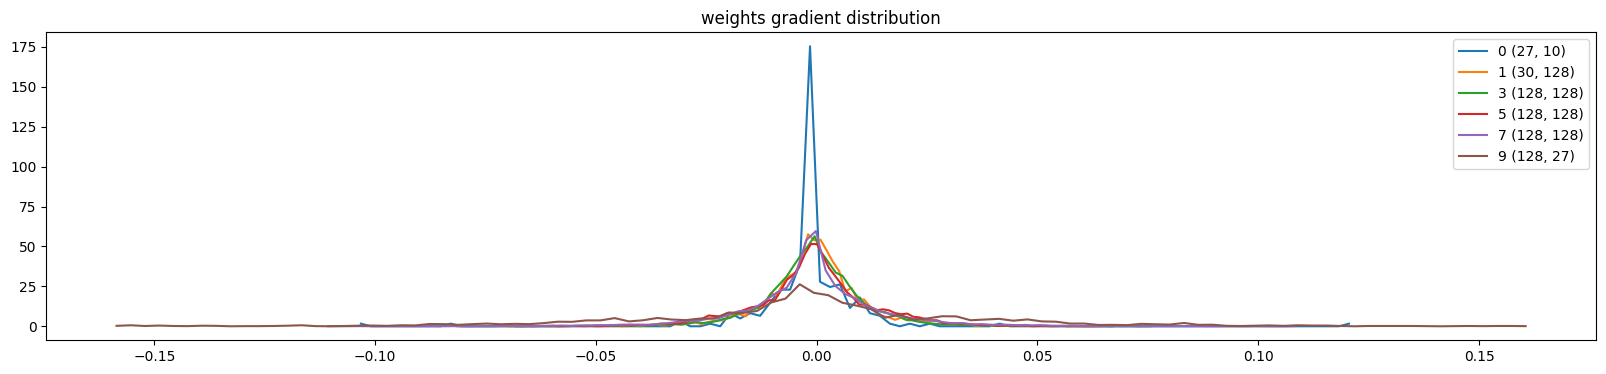

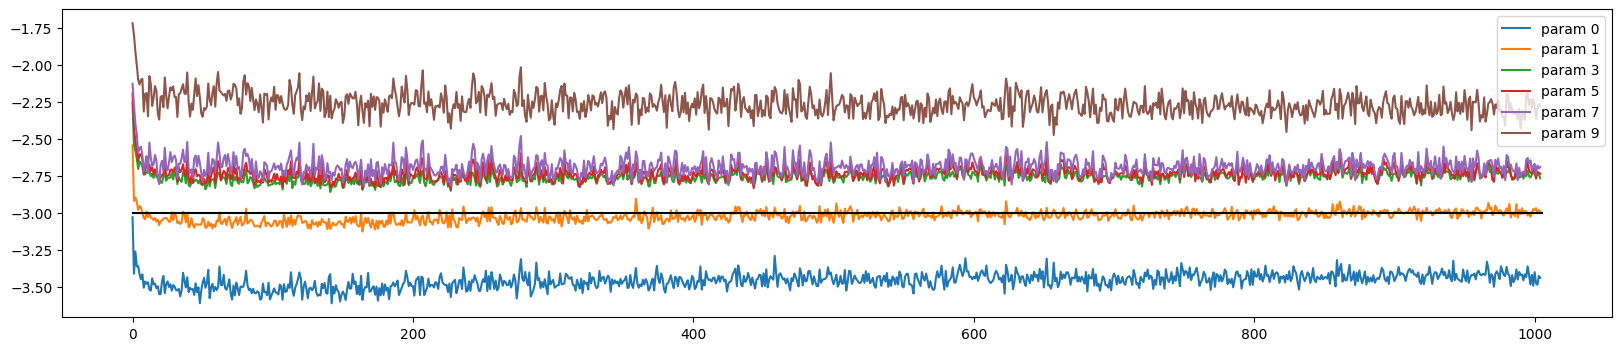

In [583]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(
    vocab_size,
    block_size,
    n_emb=10,
    n_hidden=128,
    linear_layer=LinearWithGain,
    device=device,
    gen=g
)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")
plot_forward_activations(model, layer_type=Tanh)
mb_X, mb_y = train_ds.get_mini_batch(64, device)
train_step(model, mb_X, mb_y, optimizer)
plot_backward_gradients(model, Tanh)
visualize_weights_gradients(model)
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
visualize_gradient_to_weight_ratio(optimizer)

#### After few manual runs I found that 7e-2 Is a good one, so it 70 times bigger than previous value

In [584]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=4.032634735107422, init_v_loss=4.033323287963867
epoch=0: cur_avg_train_loss=2.5057306246928484, cur_val_loss=2.3769373893737793
epoch=1: cur_avg_train_loss=2.33052003098674, cur_val_loss=2.305842399597168
epoch=2: cur_avg_train_loss=2.2759832409748517, cur_val_loss=2.2671358585357666
epoch=3: cur_avg_train_loss=2.243176576507044, cur_val_loss=2.2509727478027344
epoch=4: cur_avg_train_loss=2.219999269066579, cur_val_loss=2.21622896194458
epoch=5: cur_avg_train_loss=2.201791476680938, cur_val_loss=2.2169456481933594
epoch=6: cur_avg_train_loss=2.187222848019277, cur_val_loss=2.194779634475708
epoch=7: cur_avg_train_loss=2.1739983130023774, cur_val_loss=2.1919515132904053
epoch=8: cur_avg_train_loss=2.1633803926378605, cur_val_loss=2.176971673965454
epoch=9: cur_avg_train_loss=2.1521200050870735, cur_val_loss=2.16345477104187
epoch=10: cur_avg_train_loss=2.142588488015521, cur_val_loss=2.1610002517700195
epoch=11: cur_avg_train_loss=2.133725673435219, c

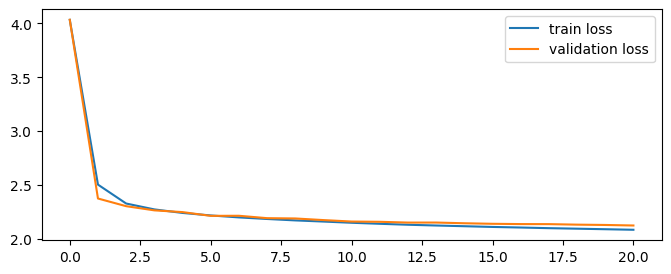

In [585]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [589]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

kameson.
wilynn.
eli.
jurwaygasla.
maye.
eli.
zyia.
slasen.
kylie.
ruhen.
magdy.
nah.
rael.
zakadar.
elis.

test_loss=tensor(2.1210)


#### Last samples are nice, loss values are the best

### Decrease last layer weights to make initial prediction probability uniform

- Loss at the beginning may take 10-100 times bigger value than at other learning steps.
- We actually want to initialize our NN to the state so all classes are equally distibuted => logits are close to each other
- to achieve this we can decrease last layer weights and biases to small values

In [592]:
# in case of equaly distributed 27 classes (next token) we would expect 1/27 prob of each, so the loss is:
expected_initial_loss = -torch.tensor(1/27).log() # negative log likelihood
expected_initial_loss

tensor(3.2958)

In [591]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train2(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

model.nelement()=57257
init_t_loss=3.297201156616211, init_v_loss=3.2972497940063477
epoch=0: cur_avg_train_loss=2.561456309134267, cur_val_loss=2.3938987255096436
epoch=1: cur_avg_train_loss=2.3464902328305035, cur_val_loss=2.3111624717712402
epoch=2: cur_avg_train_loss=2.286303997039795, cur_val_loss=2.2659544944763184
epoch=3: cur_avg_train_loss=2.253485367473853, cur_val_loss=2.2495696544647217
epoch=4: cur_avg_train_loss=2.2294911490493563, cur_val_loss=2.2266623973846436
epoch=5: cur_avg_train_loss=2.210995167731289, cur_val_loss=2.227039098739624
epoch=6: cur_avg_train_loss=2.19596261344108, cur_val_loss=2.1997811794281006
epoch=7: cur_avg_train_loss=2.1830982543320294, cur_val_loss=2.1985228061676025
epoch=8: cur_avg_train_loss=2.1712396679171526, cur_val_loss=2.187979221343994
epoch=9: cur_avg_train_loss=2.1605433182887346, cur_val_loss=2.1803979873657227
epoch=10: cur_avg_train_loss=2.1518349617838384, cur_val_loss=2.173661231994629
epoch=11: cur_avg_train_loss=2.142399120259

ashivi.
aalinly.
zese.
radee.
visaberth.
judan.
criston.
jiqus.
endi.
gim.
eakarysterlinssia.
joziya.
malowynn.
saypa.
aisyn.

test_loss=tensor(2.1277)


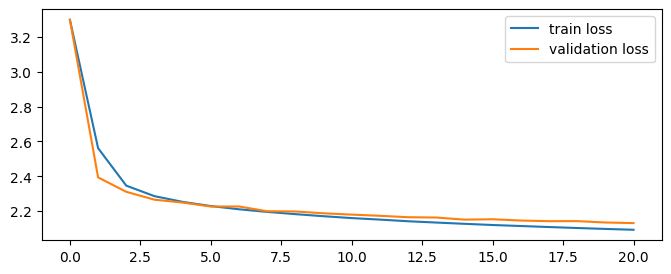

In [594]:
plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')